## Projet AGIR : modèle de prédiction
#### Rappel de l'objectif
On cherche à prédire si l'évolution en proportion du DPE ou du climat peut influer la consommation électrique, pour permettre à l'Etat d'évaluer la mise en place de politiques sur le DPE ou en anticipation de l'évolution climatique.

#### Prérequis
Afin que le code fonctionne au mieux, faites en sorte de respecter les 3 conditions de mon fichier requirements.txt. Vous pouvez utiliser d'autres versions mais à votre péril ;)

#### Outil proposé
Dans un premier temps, bien relire ce qui a été marqué sur le drive, puis lire le module model.py, qui propose les 3 fonctions : create_model_data, train_model, use_model

#### Etape 1 : jeu de données

Il faudra évidemment le réadapter pour avoir les colonnes souhaitées à l'entraînement. Ici j'ouvre très simplement un fichier à titre d'exemple.

In [7]:
import pandas as pd
from model import ModelCreator

ModuleNotFoundError: No module named 'ace_tools'

In [8]:
data = pd.read_csv('C:/Users/msi/Desktop/projetAgir/data/data-final.csv')
data.columns

Index(['N°DPE', 'Etiquette_GES', 'Type_bâtiment', 'Classe_inertie_bâtiment',
       'Adresse', 'Etiquette_DPE', 'N°_région_(BAN)', 'Nom Commune',
       'Code_postal_(brut)', 'Conso_5_usages_é_finale_énergie_n°1',
       'Conso_chauffage_é_finale_énergie_n°1',
       'Type_énergie_principale_chauffage', 'Conso_chauffage_é_primaire',
       'Conso_5_usages_é_primaire', 'Chauffage_électrique', 'Année_x',
       'Code IRIS', 'Nom IRIS', 'Numéro de voie', 'Indice de répétition',
       'Type de voie', 'Libellé de voie', 'Code Commune', 'Segment de client',
       'Nombre de logements',
       'Consommation annuelle totale de l'adresse (MWh)',
       'Consommation annuelle moyenne par logement de l'adresse (MWh)',
       'Consommation annuelle moyenne de la commune (MWh)', 'Code EPCI',
       'Code Région', 'Tri des adresses', 'Température moyenne mensuelle',
       'Température maximale', 'Température minimale', 'Date', 'Saison',
       'Année_y', 'Température moyenne annuelle', 'Centile_2

In [9]:
df_raw = data.copy()

# Filter relevant columns
df_filtered = df_raw[[
    "Nom Commune", "Année_y", "Saison", "Etiquette_DPE",
    "Température moyenne mensuelle", "Centile_25%", "Centile_50% (Médiane)",
    "Centile_75%", "N°_région_(BAN)", "Consommation annuelle moyenne par logement de l'adresse (MWh)"
]]

# DPE ratio per region-year
dpe_counts = (
    df_filtered
    .groupby(["N°_région_(BAN)", "Année_y", "Etiquette_DPE"])
    .size()
    .unstack(fill_value=0)
)

dpe_columns = ['A', 'B', 'C', 'D', 'E', 'F']
for col in dpe_columns:
    if col not in dpe_counts.columns:
        dpe_counts[col] = 0

dpe_counts["Total"] = dpe_counts[dpe_columns].sum(axis=1)
for col in dpe_columns:
    dpe_counts[f"DPE_{col}"] = dpe_counts[col] / dpe_counts["Total"]

dpe_ratios = dpe_counts[[f"DPE_{col}" for col in dpe_columns]].reset_index()

# Seasonal medians of average temperature
seasonal_medians = (
    df_filtered
    .groupby(["N°_région_(BAN)", "Année_y", "Saison"])["Température moyenne mensuelle"]
    .median()
    .unstack()
    .reset_index()
    .rename(columns={
        "Hiver": "mediane_hiver",
        "Printemps": "mediane_printemps",
        "Été": "mediane_ete",
        "Automne": "mediane_automne"
    })
)

# Annual centiles
annual_centiles = (
    df_filtered
    .groupby(["N°_région_(BAN)", "Année_y"])[["Centile_25%", "Centile_50% (Médiane)", "Centile_75%"]]
    .median()
    .reset_index()
)

# Target value (mean consumption per region-year)
region_targets = (
    df_filtered
    .groupby(["N°_région_(BAN)", "Année_y"])["Consommation annuelle moyenne par logement de l'adresse (MWh)"]
    .mean()
    .reset_index()
)

# Final merge
aggregated_df = dpe_ratios.merge(seasonal_medians, on=["N°_région_(BAN)", "Année_y"], how="left")
aggregated_df = aggregated_df.merge(annual_centiles, on=["N°_région_(BAN)", "Année_y"], how="left")
aggregated_df = aggregated_df.merge(region_targets, on=["N°_région_(BAN)", "Année_y"], how="left")

aggregated_df

,N°_région_(BAN),Année_y,DPE_A,DPE_B,DPE_C,DPE_D,DPE_E,DPE_F,mediane_automne,mediane_hiver,mediane_printemps,mediane_ete,Centile_25%,Centile_50% (Médiane),Centile_75%,Consommation annuelle moyenne par logement de l'adresse (MWh)
0,11.0,2018,0.000000,0.056180,0.202247,0.337079,0.404494,0.0,13.3,14.5,15.1,18.1,12.975,16.55,19.725,3.272157
1,11.0,2019,0.000000,0.055249,0.204420,0.342541,0.397790,0.0,14.0,15.8,12.5,18.0,13.775,16.95,19.675,3.246041
2,11.0,2020,0.000000,0.039370,0.228346,0.370079,0.362205,0.0,17.1,14.9,14.6,18.0,15.075,18.40,21.600,2.985444
3,11.0,2021,0.000000,0.030288,0.251388,0.354871,0.363453,0.0,17.2,15.6,15.0,18.5,16.425,20.45,22.900,2.899324
4,11.0,2022,0.000000,0.030120,0.253012,0.355422,0.361446,0.0,16.2,15.3,17.0,18.8,16.225,19.80,22.500,2.893789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,93.0,2019,0.020882,0.000000,0.375870,0.526682,0.076566,0.0,17.3,9.4,12.9,24.6,11.575,14.25,22.350,2.781738
68,93.0,2020,0.020134,0.000000,0.362416,0.543624,0.073826,0.0,14.3,9.3,14.1,24.2,11.575,14.70,21.075,2.745010
69,93.0,2021,0.020134,0.000000,0.362416,0.543624,0.073826,0.0,15.8,8.7,12.0,23.5,11.025,14.60,22.000,2.745010
70,93.0,2022,0.020134,0.000000,0.362416,0.543624,0.073826,0.0,18.1,9.5,13.5,26.0,10.575,16.20,22.900,2.745010


### Préface au modèle : objet ModelCreator

Cet objet est la solution la plus simple pour conserver les données d'une fonction à l'autre. Lisez bien la documentation pour la comprendre.

#### Etape 2 : normalisation des données

La fonction create_model_data va se charger de normaliser les données. Le seul travail à faire de votre côté est la distinction entre les variable quantitatives (scalaires, donc numériques et unidimensionnelles), et les variables catégorielle (autrement dit qualitatives)

In [15]:
mc= ModelCreator(aggregated_df)
mc.create_model_data(
    column_to_predict="Consommation annuelle moyenne par logement de l'adresse (MWh)",
    quantitative_variables=[
        "Centile_25%", "Centile_50% (Médiane)", "Centile_75%",
        "mediane_automne", "mediane_hiver", "mediane_printemps", "mediane_ete",
        "DPE_A", "DPE_B", "DPE_C", "DPE_D", "DPE_E", "DPE_F"
    ],
    categorical_variables=["N°_région_(BAN)"],
    test_size=0.2,  # Adjust the test size as needed
    random_state=42  # Ensure reproducibility
)



KeyError: "None of [Index(['Centile_25%', 'Centile_75%'], dtype='object')] are in the [columns]"

#### Etape 3 : Entraînement d'un modèle MLPRegressor

Un MLPRegressor est un réseau de neurones. Un réseau de neurones est une sucession de fonctions polynomiales enveloppées chacune d'une fonction dite "d'activation", la résultante étant une grande fonction. Chaque facteur constant du polynôme est inconnu et est l'objet de l'entraînement. L'entrée de la fonction sont les variables quantitatives et catégorielles choisies, et la sortie de la fonction est la "column_to_predict". Dans notre cas, il s'agit d'un modèle de régression, dans le sens où l'entraînement porte sur une variable quantitative (à l'opposé d'un classifieur où la sortie est une variable catégorielle).

Je propose dans le module de contrôler la "taille" de cette fonction. Chaque élément de la liste "network_layer" ajoute un polynôme, et la valeur indique la taille du polynôme. La valeur max_iterations limite le temps d'entraînement si le modèle à du mal à converger, c'est à dire parvenir à un stade de l'entraînement où le modèle n'évolue plus de façon significative.

Les résultats de la fonction se découpent en 3 parties :
    - La loss curve. C'est une série d'un calcul que l'on appelle la perte pour un modèle. Cette perte mesure le taux d'erreur à l'entraînement, et guide également l'entraînement, car l'ajustement du modèle est fait pour minimiser cette perte. Elle peut être tracée, sachant qu'une courbe de perte idéale est quand elle décroît régulièrement jusqu'à atteindre un plancher (converge) le plus proche de 0 possible
    - Le score d'entraînement. C'est une métrique arbitraire pour mesurer l'efficacité concréte du modèle, basé sur la formule du R². Cette formule pénalise fortement les écarts marqués à la réalité attendue.
    - Le score de test. Pareil que la précédente, mais cette fois appliqué au jeu de données qui a été mis à l'écart de l'entraînement. Il permet de contrôler que le modèle n'a pas juste "appris par coeur" les données d'entraînement.

Nommons le score d'entraînement St celui de test Se :
    - St sera généralement supérieur à Se. On cherche au mieux à faire en sorte que St = Se
    - Se = St = 1 indique que le modèle est parfait. C'est l'utopie qui est visée par nos modèles.
    - Se = 0 indique que le modèle ne fait pas mieux que si on prenait simplement la moyenne des valeurs connues de sortie pour prédire.
    - Se < 0 indique que le modèle est moins performant que la moyenne. Il est alors inenvisageable d'utiliser le modèle.

Je ne sais pas ce que permettra le jeu de données, mais avec le peu de temps qu'on a dépasser Se > 0.50 sera déjà une très bonne preuve de potentiel. Mais ne vous focalisez pas dessus. Se > 0 est la vraie base à viser.

In [16]:
loss_curve, score_train, score_test = mc.train_model(
    network_layers=[20, 15, 10],  
    max_iterations=500,
    random_state=42         
)

print(f"Valeur minimale de la fonction de perte: {min(loss_curve):.4f}")
print(f"Score sur les données d'entraînement: {score_train:.4f}")
print(f"Score sur les données de test: {score_test:.4f}")


Valeur minimale de la fonction de perte: 0.0113
Score sur les données d'entraînement: 0.9389
Score sur les données de test: 0.7902


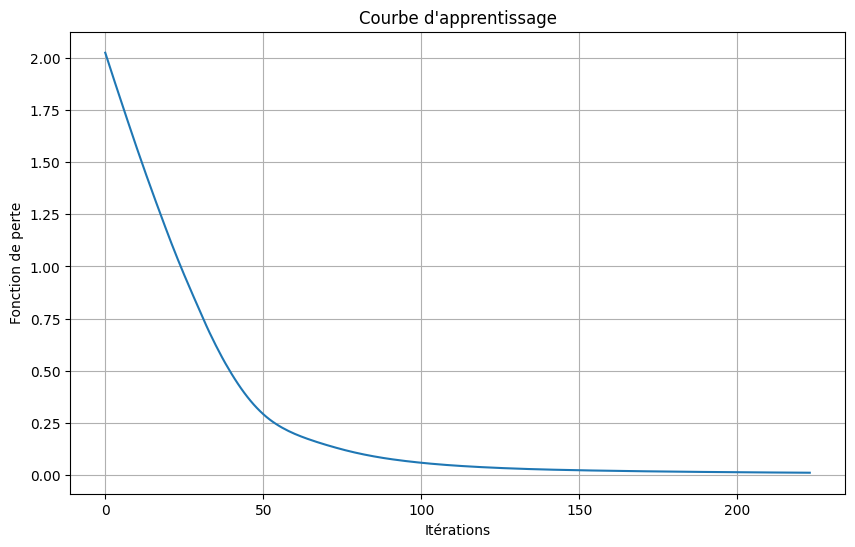

In [17]:
# Visualiser la courbe d'apprentissage
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_curve)
plt.title('Courbe d\'apprentissage')
plt.xlabel('Itérations')
plt.ylabel('Fonction de perte')
plt.grid(True)
plt.show()

- Le modèle commence avec une perte élevée (~3), ce qui est normal au début.
- La perte diminue de manière continue et rapide : *le modèle apprend correctement*.
- À partir d'environ 100 itérations, la perte se stabilise autour de *0.01*, ce qui montre une bonne *convergence*.
- La courbe est *lisse et décroissante*, sans oscillations violentes, ce qui indique *un bon réglage des hyperparamètres* (pas de surapprentissage visible ici).

#### 🟢 Conclusion :
Le modèle s'entraîne bien et atteint un bon niveau de précision sur les données d'entraînement. Il reste maintenant à vérifier que ce bon apprentissage *se généralise* au jeu de test, à l'aide du score_test.

#### Etape 4 : prédiction

Si vous avez un modèle qui marche, vous pourrez proposer une prédiction. L'entrée doit être présentée sous forme d'un dictionnaire. Si vous voulez faire plusieurs prédictions en utilisant toutes les fonctionnalités de ma fonction, demandez moi ou observez le code que j'ai fait.

In [18]:
prediction_input = {
    "Centile_25%": 4.1,
    "Centile_50% (Médiane)": 5.3,
    "Centile_75%": 7.2,
    "mediane_automne": 12.0,
    "mediane_hiver": 5.1,
    "mediane_printemps": 13.3,
    "mediane_ete": 22.8,
    "DPE_A": 0.05,
    "DPE_B": 0.15,
    "DPE_C": 0.30,
    "DPE_D": 0.25,
    "DPE_E": 0.15,
    "DPE_F": 0.10,
    "N°_région_(BAN)": 11.0  
}

prediction = mc.use_model(prediction_input)
print(f"Consommation prédite: {prediction[0]:.4f} MWh")


Consommation prédite: 3.7435 MWh
